In [1]:
import datetime
import joblib
from pathlib import Path
from typing import Any
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import classification_report

Path("models/").mkdir(exist_ok=True)

phase_map = {
    0: "clear",
    1: "liquid",
    2: "ice",
    3: "mixed",
    4: "drizzle",
    5: "liq_driz",
    6: "rain",
    7: "snow",
    8: "unknown",
}



def get_model_filepath(label: str) -> Path:
    yyyymmdd_hhmmss = datetime.datetime.now().strftime("%Y%m%d.%H%M%S")
    return Path(f"models/{label}.{yyyymmdd_hhmmss}.joblib")

def save_model(model: Any, label: str) -> Path:
    _model_path = get_model_filepath(label)
    joblib.dump(model, _model_path)
    print(f"Wrote model file to {_model_path}")
    return _model_path

def plot_confusion_matrix_pairs(
    *true_pred_pairs: tuple[pd.DataFrame, pd.DataFrame],
    plot_titles: list[str],  # Column titles, not output labels
):
    fig, axs = plt.subplots(
        ncols=len(true_pred_pairs), sharey=True, figsize=(24, 24)
    )

    for i, ((y_true, y_pred), title) in enumerate(zip(true_pred_pairs, plot_titles)):
        accuracy = metrics.accuracy_score(y_true, y_pred)
        print(f"{title} accuracy={100*accuracy:.3f}%")
        _ = metrics.ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            labels=list(phase_map.values())[1:],
            ax=axs[i],
            colorbar=False,
        )
        axs[i].set_title(f"{title} (size={len(y_true.index)})")

    return fig


In [2]:
def get_cnn_feature_cols(df: pd.DataFrame) -> pd.DataFrame:
    """The input data to this notebook is an aggregated dataframe that was built for the
    cloudphase poster for the 2023 ARM/ASR PI meeting. Some of the variable names were
    changed as part of the aggregation process. The CNN uses the VAP variable names. This
    function just changes the variable names back to what the VAP calls them and selects
    just the columns that are used by the CNN, so that any comparison between the CNN and
    the RF / MLP models is fair."""
    agg_to_cnn_feature_cols = {
        "temp": "temp",
        "mpl_backscatter": "mpl_backscatter",
        "mpl_linear_depol_ratio": "mpl_linear_depol_ratio",
        "radar_reflectivity": "reflectivity",
        "radar_ldr": "radar_linear_depolarization_ratio",
        "radar_spectral_width": "spectral_width",
        "radar_mdv": "mean_doppler_velocity",
        "mwr_lwp": "mwrret1liljclou_be_lwp",
    }
    keep_vars = ["cloud_phase_mplgr", *list(agg_to_cnn_feature_cols.values())]
    df = df.rename(columns=agg_to_cnn_feature_cols)[keep_vars]
    return df

In [3]:
TRAIN_CACHE = Path("Handlabelplusoriginals/trainingvalid/train_data_v14.parquet") #JUNE 25TH: CHANGE TO V14
VALID_CACHE = Path("Handlabelplusoriginals/trainingvalid/valid_data_v14.parquet") #JUNE 25TH: CHANGE TO V14


if not TRAIN_CACHE.exists():
    N_TRAIN = 40_000  # per phase classification
    N_VALID = 10_000

    print("creating training/validation data...")

    data = pd.read_parquet("Handlabelplusoriginals/nsa-edited") #JUNE 25TH: EDIT THIS TO NSA-EDITED
    data = get_cnn_feature_cols(data)  # limit to columns used in the cnn, + time/height
    data = data.reset_index()
    data = data[data["time"].between("2021-01-01", "2021-02-28")]  # Summer Project
    data = data.dropna(subset=["cloud_phase_mplgr"])
    data["cloud_phase_mplgr"] = data["cloud_phase_mplgr"].astype(int).map(phase_map).astype("category")

    phase_data = {}
    for phase in tqdm(list(phase_map.values())[1:]):  # none that are type 'clear'
        phase_data[phase] = data[data["cloud_phase_mplgr"] == phase]
        if len(phase_data[phase]) < max(N_TRAIN, N_VALID):
            print(
                f"WARNING: not enough {phase} points. Found {len(phase_data[phase])},"
                f" but wanted {max(N_TRAIN, N_VALID)}"
            )

    # Join into training/validation sets
    _train: dict[str, pd.DataFrame] = {}
    _valid: dict[str, pd.DataFrame] = {}

    for phase in tqdm(phase_data):  # none that are type 'clear'
        sample = phase_data[phase].sample(
            min(N_TRAIN + N_VALID, len(phase_data[phase]))
        )
        _train[phase] = sample.iloc[:N_TRAIN]
        _valid[phase] = sample.iloc[N_TRAIN:N_TRAIN + N_VALID]

    train: pd.DataFrame = shuffle(pd.concat(_train.values())).reset_index(drop=True)
    valid: pd.DataFrame = shuffle(pd.concat(_valid.values())).reset_index(drop=True)

    # Save to disk
    TRAIN_CACHE.parent.mkdir(exist_ok=True)
    train.to_parquet(TRAIN_CACHE)
    valid.to_parquet(VALID_CACHE)

    del data
    del train
    del valid
    del _train
    del _valid
    del phase_data

# Load data
train = pd.read_parquet(TRAIN_CACHE)
valid = pd.read_parquet(VALID_CACHE)

# Remove unknown pixels
train = train[train["cloud_phase_mplgr"] != 'unknown']
valid = valid[valid["cloud_phase_mplgr"] != 'unknown']

# don't rely on time or height features
train = train.drop(columns=["time", "height"])
valid = valid.drop(columns=["time", "height"])

# split into X & y sets
y_train, X_train = train.pop("cloud_phase_mplgr"), train
y_valid, X_valid = valid.pop("cloud_phase_mplgr"), valid

# Just for models that don't handle NaNs well
# X_train_filled = X_train.fillna(-9999)
# X_valid_filled = X_valid.fillna(-9999)

X_train_filled = X_train.fillna(0)
X_valid_filled = X_valid.fillna(0)

print(len(X_train))
print(len(X_valid))

creating training/validation data...


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

161074
40000


In [4]:
X_train.head()

,temp,mpl_backscatter,mpl_linear_depol_ratio,reflectivity,radar_linear_depolarization_ratio,spectral_width,mean_doppler_velocity,mwrret1liljclou_be_lwp
0,-14.326506,0.078973,0.085378,9.748016,-20.295120,0.143170,-0.873124,1.917603
1,-7.365935,0.037511,0.127418,10.602318,-20.418087,0.130512,-0.601629,NaN
2,-21.239449,0.000896,0.107104,-14.131268,-19.672274,0.349553,-0.452998,77.336166
3,-18.184942,0.194178,0.074212,5.219007,-19.110302,0.157058,-0.838426,NaN
4,-30.728657,0.001392,0.218070,-22.044050,-20.661461,0.036337,-0.427268,1.462071


In [5]:
# pipe = Pipeline(
#     [
#         ("scale", QuantileTransformer()),
#         ("model", DecisionTreeClassifier())
#     ]
# )
# model = pipe.fit(X_train, y_train)
# y_pred_train = model.predict(X_train)
# y_pred_valid = model.predict(X_valid)


# print(classification_report(y_true=y_valid, y_pred=y_pred_valid, digits=3))
# with plt.style.context("style.mplstyle"):
#     plot_confusion_matrix_pairs(
#         *[(y_train, y_pred_train), (y_valid, y_pred_valid)],
#         plot_titles=["Training", "Validation"]
#     )
#     plt.show()


In [6]:
# pipe = Pipeline(
#     [
#         # ("scale", QuantileTransformer(random_state=112341)),
#         ("scale", StandardScaler()),
#         ("model", HistGradientBoostingClassifier(
#             # learning_rate=0.01, # 0.1 default,
#             random_state=112341,
#             max_iter=250, # default 100
#             max_leaf_nodes=511,  # default is 31
#             min_samples_leaf=500, # default 20
#             l2_regularization=0.75, # default 0
#             n_iter_no_change=25, # default 10
#         ))
#     ]
# )
# model = pipe.fit(X_train, y_train)
# y_pred_train = model.predict(X_train)
# y_pred_valid = model.predict(X_valid)
# # save_model(model, "histgrad_data6")

# print(classification_report(y_true=y_valid, y_pred=y_pred_valid, digits=3))
# with plt.style.context("style.mplstyle"):
#     plot_confusion_matrix_pairs(
#         *[(y_train, y_pred_train), (y_valid, y_pred_valid)],
#         plot_titles=["Training", "Validation"]
#     )
#     plt.show()


Wrote model file to models/harrissummerproject.20240624.223221.joblib


/home/charris/.conda/envs/Summer_Project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charris/.conda/envs/Summer_Project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charris/.conda/envs/Summer_Project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

     drizzle      0.000     0.000     0.000         0
         ice      0.847     0.836     0.842     10000
      liquid      0.892     0.907     0.899     10000
       mixed      0.877     0.867     0.872     10000
        rain      0.000     0.000     0.000         0
        snow      0.980     0.987     0.984     10000

    accuracy                          0.899     40000
   macro avg      0.599     0.600     0.599     40000
weighted avg      0.899     0.899     0.899     40000

Training accuracy=99.999%
Validation accuracy=89.935%


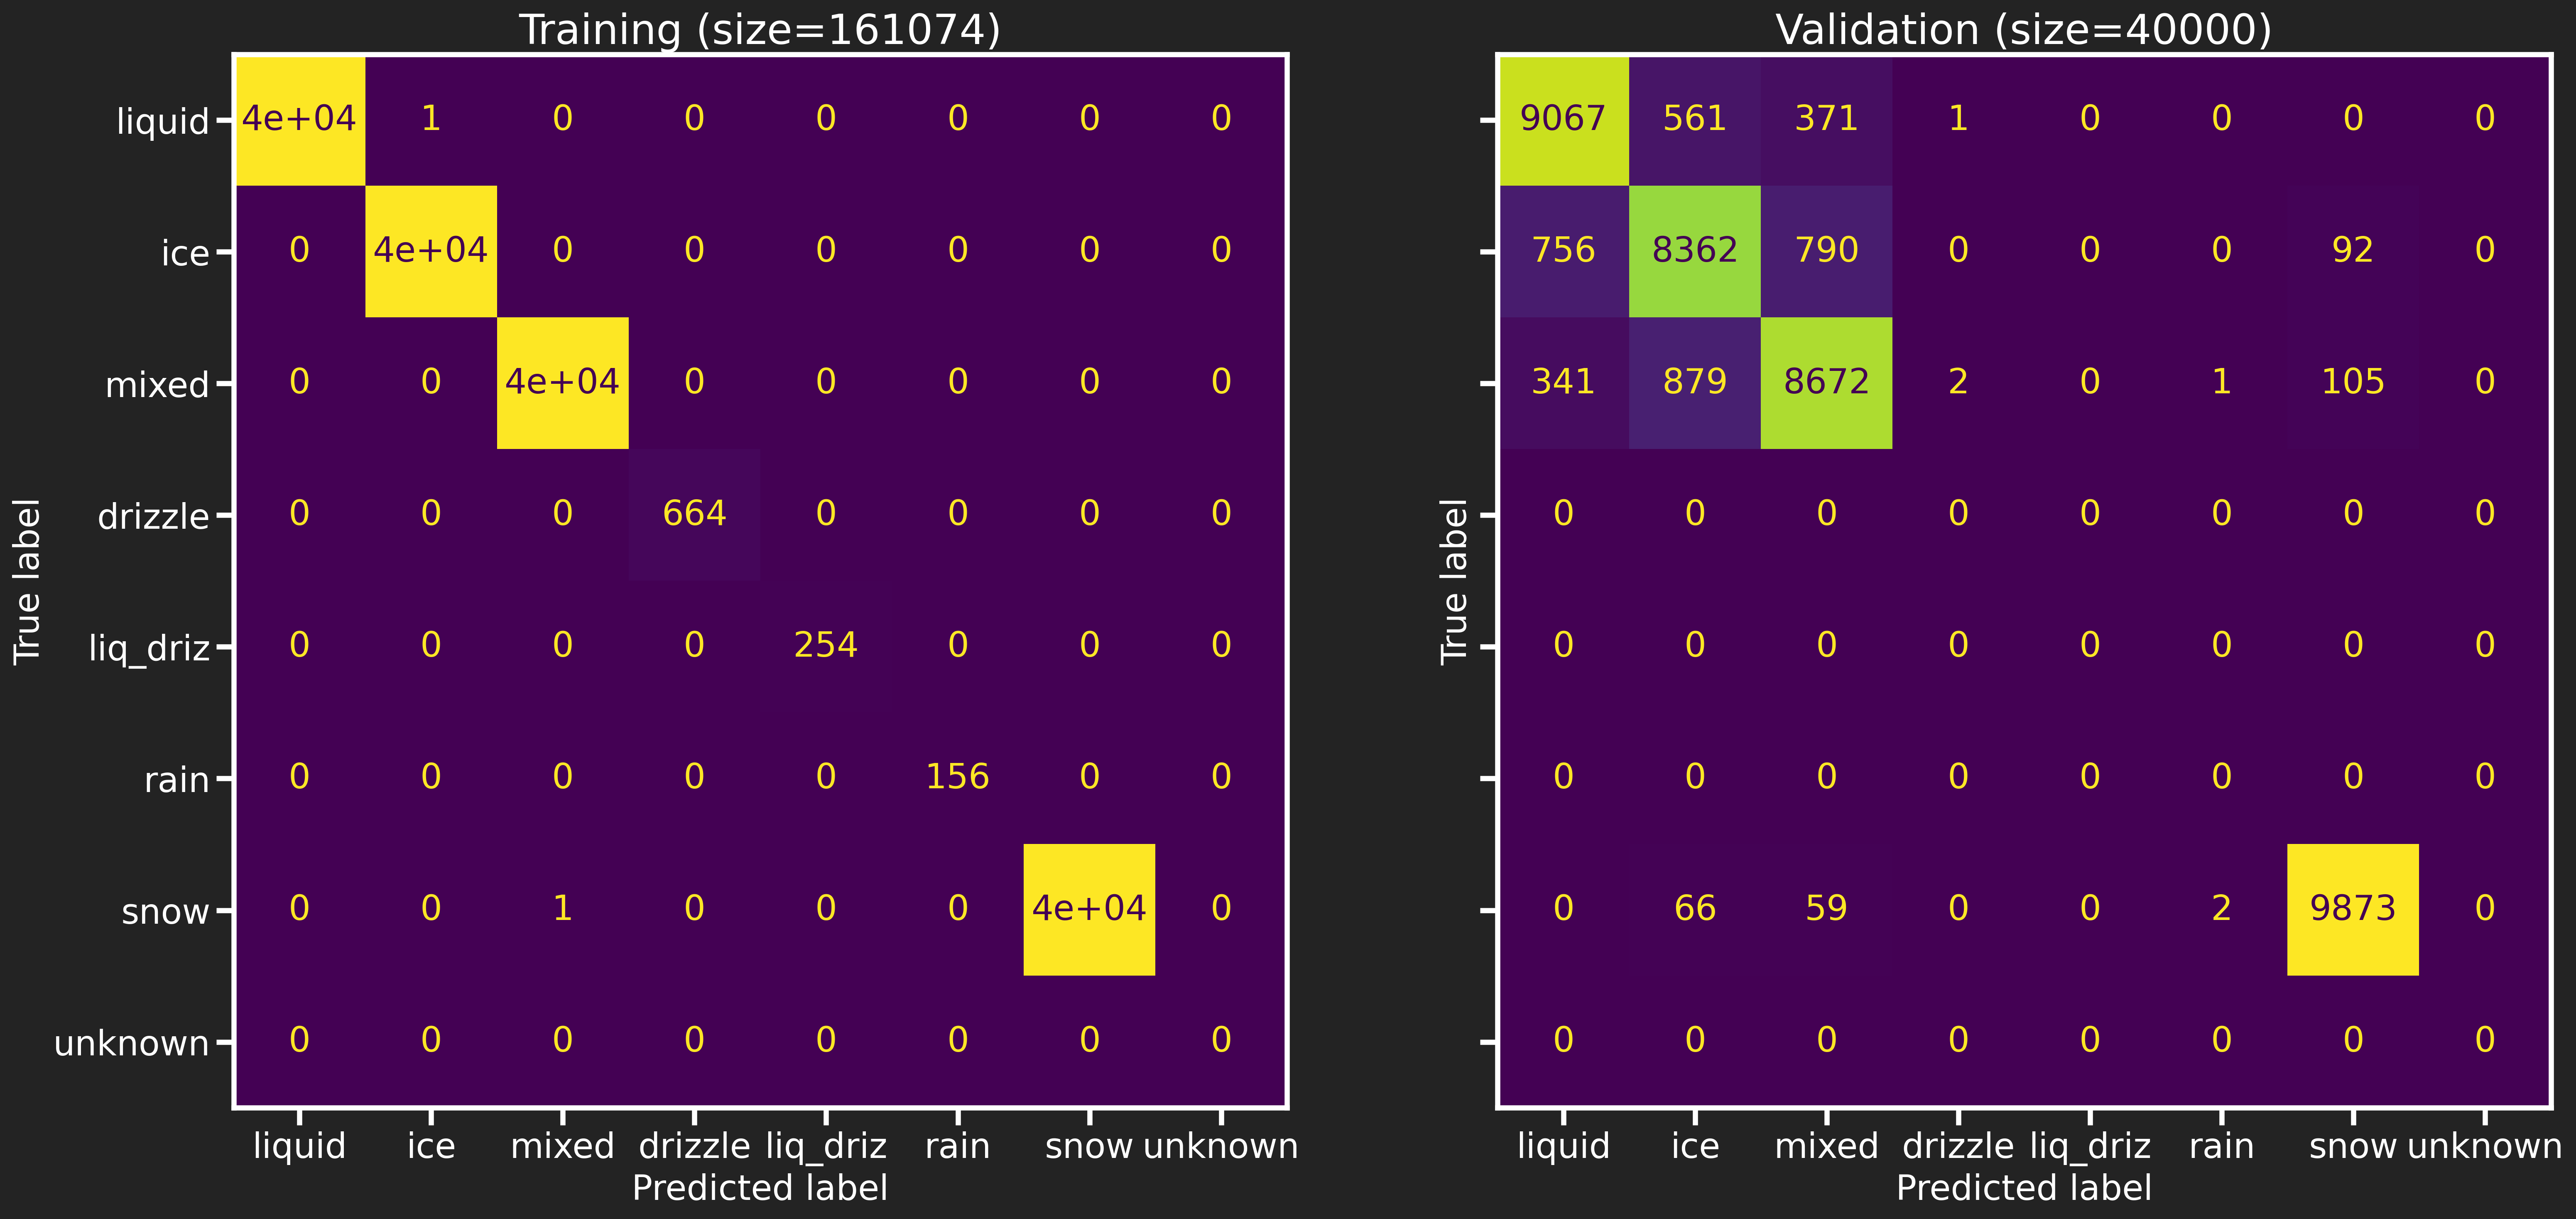

In [12]:
N_RF_TRAIN = None

pipe = Pipeline(
    [
        # ("scale", QuantileTransformer(random_state=112341)),
        ("scale", StandardScaler()),
        ("model", RandomForestClassifier(
            random_state=112341,
            # n_estimators=40,
            # max_features=2,
            # max_depth=21,
            # max_leaf_nodes=None,
            # class_weight="balanced_subsample",
            # max_samples=100_000
        ))
    ]
)

model = pipe.fit(X_train_filled.iloc[:N_RF_TRAIN], y_train.iloc[:N_RF_TRAIN])
y_pred_train = model.predict(X_train_filled.iloc[:N_RF_TRAIN])
y_pred_valid = model.predict(X_valid_filled)
save_model(model, "harrissummerproject")

print(classification_report(y_true=y_valid, y_pred=y_pred_valid, digits=3))
with plt.style.context("code.arm.gov/cloudphase/notebooks/fy23/style.mplstyle"):
    plot_confusion_matrix_pairs(
        *[(y_train.iloc[:N_RF_TRAIN], y_pred_train), (y_valid, y_pred_valid)],
        plot_titles=["Training", "Validation"]
    )
    plt.show()


In [8]:
# N_ADA_TRAIN = None

# pipe = Pipeline(
#     [
#         ("scale", QuantileTransformer(random_state=112341)),
#         # ("scale", StandardScaler()),
#         ("model", AdaBoostClassifier(
#             estimator=DecisionTreeClassifier(max_depth=31),
#             random_state=112341,
#         ))
#     ]
# )
# model = pipe.fit(X_train_filled.iloc[:N_ADA_TRAIN], y_train.iloc[:N_ADA_TRAIN])
# y_pred_train = model.predict(X_train_filled.iloc[:N_ADA_TRAIN])
# y_pred_valid = model.predict(X_valid_filled)
# # save_model(model, "ada")

# print(classification_report(y_true=y_valid, y_pred=y_pred_valid, digits=3))
# with plt.style.context("style.mplstyle"):
#     plot_confusion_matrix_pairs(
#         *[(y_train.iloc[:N_ADA_TRAIN], y_pred_train), (y_valid, y_pred_valid)],
#         plot_titles=["Training", "Validation"]
#     )
#     plt.show()


In [6]:
normalizations = {  # from Andrew -- thank you!
    "temp": lambda x: (np.clip(x, -100, 50) + 30) / 30,
    "mpl_backscatter": lambda x: (np.log(np.clip(x, 1e-8, 1e4)) + 6) / 8,
    "mpl_linear_depol_ratio": lambda x: np.clip(x, 0, 1) * 2 - 1,
    "reflectivity": lambda x: (np.clip(x, -70, 70) + 20) / 30,
    "radar_linear_depolarization_ratio": lambda x: np.clip(x + 20, -20, 20) / 6,
    "spectral_width": lambda x: np.clip(x * 5, -1, 4) - 0.5,
    "mean_doppler_velocity": lambda x: np.clip(x + 0.5, -8, 8) / 2,
    "mwrret1liljclou_be_lwp": lambda x: (np.log(np.clip(x, 0.1, 2000)) - 3) / 2,
}
X_valid_normed = X_valid.copy(deep=True)
for var, norm in normalizations.items():
    X_valid_normed[var] = norm(X_valid_normed[var]).fillna(0)

X_train_normed = X_train.copy(deep=True)
for var, norm in normalizations.items():
    X_train_normed[var] = norm(X_train_normed[var]).fillna(0)
X_train_normed.head()

,temp,mpl_backscatter,mpl_linear_depol_ratio,reflectivity,radar_linear_depolarization_ratio,spectral_width,mean_doppler_velocity,mwrret1liljclou_be_lwp
0,0.522450,0.432669,-0.829243,0.991601,-0.049187,0.215850,-0.186562,-1.174462
1,0.754469,0.339611,-0.745163,1.020077,-0.069681,0.152559,-0.050815,0.000000
2,0.292018,-0.127209,-0.785792,0.195624,0.054621,1.247766,0.023501,0.674081
3,0.393835,0.545127,-0.851575,0.840634,0.148283,0.285290,-0.169213,0.000000
4,-0.024289,-0.072126,-0.563859,-0.068135,-0.110243,-0.318313,0.036366,-1.310073


Wrote model file to models/mpl_harrissummerproject.20240625.182027.joblib


/home/charris/.conda/envs/Summer_Project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charris/.conda/envs/Summer_Project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charris/.conda/envs/Summer_Project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

     drizzle      0.000     0.000     0.000         0
         ice      0.831     0.816     0.824     10000
    liq_driz      0.000     0.000     0.000         0
      liquid      0.875     0.878     0.876     10000
       mixed      0.859     0.851     0.855     10000
        rain      0.000     0.000     0.000         0
        snow      0.969     0.990     0.979     10000

    accuracy                          0.884     40000
   macro avg      0.505     0.505     0.505     40000
weighted avg      0.884     0.884     0.884     40000

Training accuracy=89.805%
Validation accuracy=88.367%


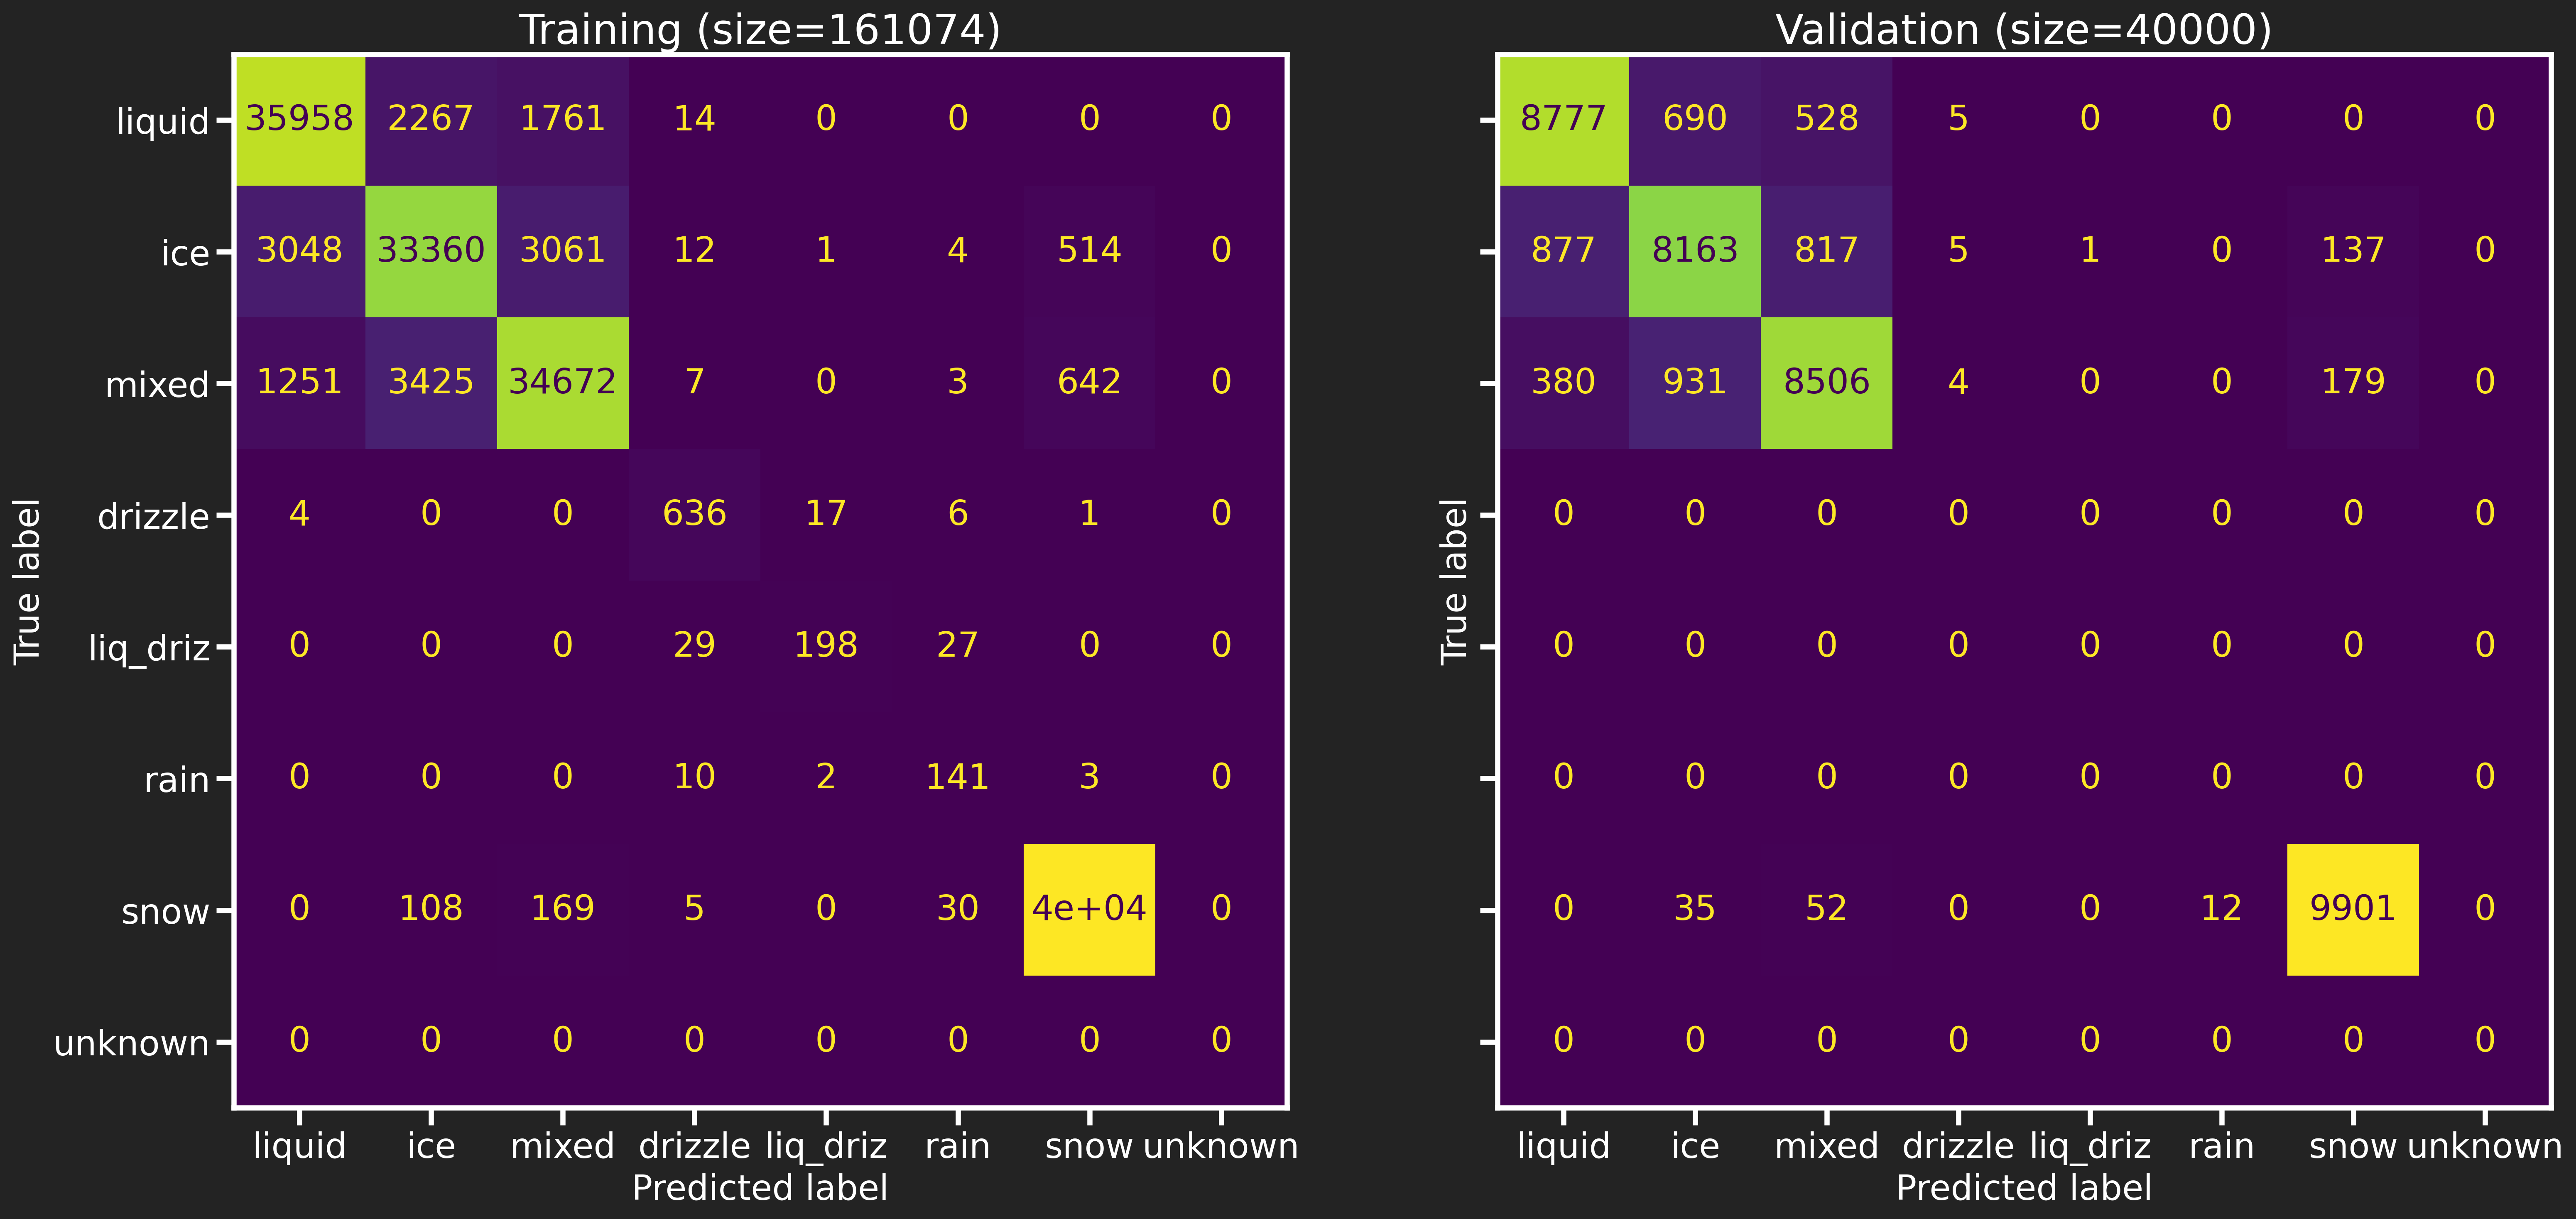

In [7]:
# N_MLP_TRAIN = 160_000
# N_MLP_TRAIN = 20_000
N_MLP_TRAIN = None

pipe = Pipeline(
    [
        # ("scale", QuantileTransformer(random_state=112341)),
        # ("scale", RobustScaler()),
        ("model", MLPClassifier(
            (100,)*5,
            random_state=112341,
            n_iter_no_change=50,
            early_stopping=True,
            learning_rate="adaptive",
            # learning_rate="invscaling",
            # batch_size=300,
            # max_iter=800,
            # n_iter_no_change=50,
            # early_stopping=True,
            validation_fraction=0.2,
        ))
    ]
)
# model = pipe.fit(X_train_filled.iloc[:N_MLP_TRAIN], y_train.iloc[:N_MLP_TRAIN])
# y_pred_train = model.predict(X_train_filled.iloc[:N_MLP_TRAIN])
# y_pred_valid = model.predict(X_valid_filled)
model = pipe.fit(X_train_normed.iloc[:N_MLP_TRAIN], y_train.iloc[:N_MLP_TRAIN])
y_pred_train = model.predict(X_train_normed.iloc[:N_MLP_TRAIN])
y_pred_valid = model.predict(X_valid_normed)
save_model(model, "mpl_harrissummerproject")


print(classification_report(y_true=y_valid, y_pred=y_pred_valid, digits=3))
with plt.style.context("code.arm.gov/cloudphase/notebooks/fy23/style.mplstyle"):
    plot_confusion_matrix_pairs(
        *[(y_train.iloc[:N_MLP_TRAIN], y_pred_train), (y_valid, y_pred_valid)],
        plot_titles=["Training", "Validation"]
    )
    plt.show()


In [9]:
mlp = joblib.load("models/mlp_160k.20231208.joblib")

FileNotFoundError: [Errno 2] No such file or directory: 'models/mlp_160k.20231208.joblib'

In [12]:
# pipe = Pipeline(
#     [
#         # ("scale", QuantileTransformer()),
#         ("scale", StandardScaler()),
#         ("model", GradientBoostingClassifier())
#     ]
# )
# model = pipe.fit(X_train_filled, y_train)
# y_pred_train = model.predict(X_train_filled)
# y_pred_valid = model.predict(X_valid_filled)


# print(classification_report(y_true=y_valid, y_pred=y_pred_valid, digits=3))
# with plt.style.context("style.mplstyle"):
#     plot_confusion_matrix_pairs(
#         *[(y_train, y_pred_train), (y_valid, y_pred_valid)],
#         plot_titles=["Training", "Validation"]
#     )
#     plt.show()


In [13]:
# pipe = Pipeline(
#     [
#         ("scale", QuantileTransformer()),
#         ("model", DecisionTreeClassifier())
#     ]
# )
# model = GridSearchCV(
#     estimator=pipe,
#     param_grid={
#         # "model__max_depth": [10, 20, 30],
#         # "model__criterion": ["gini", "log_loss"],
#         "model__max_leaf_nodes": [75, 100, 200, 300, 400, 500],
#         "model__ccp_alpha": [0, 0.00001, 0.0001, 0.001, 0.01],
#         "model__min_samples_leaf": [1, 2, 5, 10],
#     },
#     # cv=8,
#     n_jobs=6,
# )
# model = model.fit(X_train, y_train)
# save_model(model, "dt_grid_leaf_ccp")

# search = pd.DataFrame(model.cv_results_)

# y_pred_train = model.predict(X_train)
# y_pred_valid = model.predict(X_valid)

# print(classification_report(y_true=y_valid, y_pred=y_pred_valid, digits=3))
# with plt.style.context("style.mplstyle"):
#     plot_confusion_matrix_pairs(
#         *[(y_train, y_pred_train), (y_valid, y_pred_valid)],
#         plot_titles=["Training", "Validation"]
#     )
#     plt.show()


In [14]:
# pipe = Pipeline(
#     [
#         ("scale", QuantileTransformer()),
#         ("model", RandomForestClassifier())
#     ]
# )
# model = GridSearchCV(
#     estimator=pipe,
#     param_grid={
#         "model__n_estimators": [50, 100, 250, 1000],
#         "model__ccp_alpha": [0, 0.00001, 0.0001],
#         "model__min_samples_split": [2, 10, 25, 100],
#     },
#     # cv=8,
#     n_jobs=6,
# )
# model = model.fit(X_train_filled, y_train)
# save_model(model, "rf_grid_leaf_ccp")

# search = pd.DataFrame(model.cv_results_)

# y_pred_train = model.predict(X_train_filled)
# y_pred_valid = model.predict(X_valid_filled)

# print(classification_report(y_true=y_valid, y_pred=y_pred_valid, digits=3))
# with plt.style.context("style.mplstyle"):
#     plot_confusion_matrix_pairs(
#         *[(y_train, y_pred_train), (y_valid, y_pred_valid)],
#         plot_titles=["Training", "Validation"]
#     )
#     plt.show()


In [7]:
import os
os.getcwd()

'/home/charris'